In [36]:
import torch, torchvision, os, sys, math, warnings, random, cv2
import torch.nn as nn
from torchvision import transforms, utils, datasets
from torch.utils.data import DataLoader, Dataset, sampler, SubsetRandomSampler
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from PIL import Image
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

warnings.filterwarnings('ignore')
plt.ion()

ROOT_DIR = "/home/nikunjlad"

## Configuring GPU for training

In [37]:
# checking if cuda is available
train_on_gpu = torch.cuda.is_available()
torch.cuda.set_device(0)
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on Tesla T4 Device {}'.format(str(torch.cuda.current_device())))

CUDA is available!  Training on Tesla T4 Device 0


## Data Preparation

In [61]:
torch.manual_seed(333)

batch_size = 64     # number of images to be trained at any instance of time in a network
valid_size = 0.2    # 20% data to be kept as validation
transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.MNIST(os.path.join(ROOT_DIR, "data/mnist"), train=True,download=True, transform= transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]))
test_data = datasets.MNIST(os.path.join(ROOT_DIR, "data/mnist"), train=False, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]))

In [62]:
print(train_data.data.shape)   # 60000 training samples
print(test_data.data.shape)    # 10000 testing samples

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [40]:
num_train = len(train_data)           # 60000 training data
print("Number of training data samples: ", num_train)
indices = list(range(num_train))      # indices from 0 to 59999
print("First 10 indices in the training data before shuffling: ", str(indices[:10]))
np.random.shuffle(indices)            # randomly shuffle the data
split = int(math.ceil(valid_size*num_train))     # split value ie 0.2 x 60000 = 12000
print("Amount of data in the validation set based on 20% split: ", split)
valid_idx, train_idx = indices[:split], indices[split:]
print("First 5 indices in the validation set after random shuffling: ", valid_idx[:5])
print("First 5 indices in the training set after random shuffling: ", train_idx[:5])
trainrandomsampler = SubsetRandomSampler(train_idx)        # holds 48000 training sample indices
validrandomsampler = SubsetRandomSampler(valid_idx)        # holds 12000 validation sample indices

Number of training data samples:  60000
First 10 indices in the training data before shuffling:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Amount of data in the validation set based on 20% split:  12000
First 5 indices in the validation set after random shuffling:  [26644, 47389, 25393, 45788, 20382]
First 5 indices in the training set after random shuffling:  [59199, 16836, 3597, 19547, 44413]


In [41]:
print("Number of training samples:", len(trainrandomsampler))
print("Number of validation samples: ", len(validrandomsampler))

Number of training samples: 48000
Number of validation samples:  12000


In [42]:
# creates training and validation data loaders based on training and validation samplers with batch size of 64
trainloader = DataLoader(train_data, batch_size=batch_size, sampler=trainrandomsampler)  
validloader = DataLoader(train_data, batch_size=batch_size, sampler=validrandomsampler)
testloader = DataLoader(test_data, batch_size=batch_size)   # testing data with batch size of 64

In [43]:
print("Number of training samples: ", len(trainrandomsampler))
print("{} batches each having 64 samples".format(str(len(trainloader))))
print("Number of validation samples: ", len(validrandomsampler))
print("{} batches each having 64 samples".format(str(len(validloader))))
print("Number of testing samples: ", test_data.data.shape[0])
print("{} batches each having 64 samples".format(str(len(testloader))))

Number of training samples:  48000
750 batches each having 64 samples
Number of validation samples:  12000
188 batches each having 64 samples
Number of testing samples:  10000
157 batches each having 64 samples


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch image tensor dimensions:  torch.Size([64, 1, 28, 28])
Batch label tensor dimensions:  torch.Size([64])


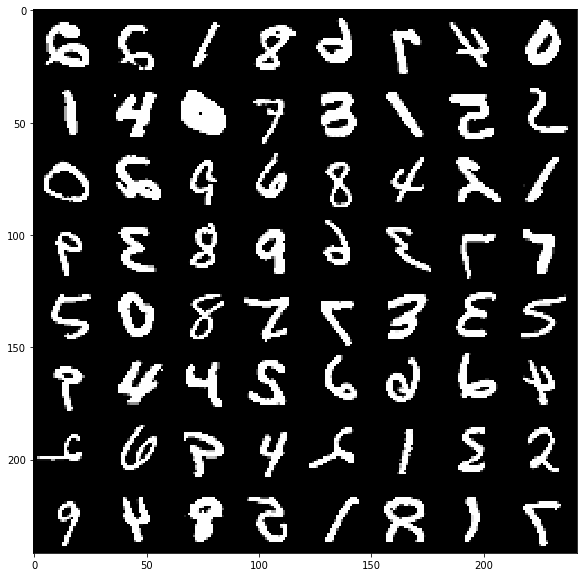

In [44]:
batch = next(iter(trainloader))
images, labels = batch

grid = torchvision.utils.make_grid(images[:64], nrow=8)
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(grid, (1,2,0)))

for data, target in trainloader:
    print("Batch image tensor dimensions: ", data.shape)
    print("Batch label tensor dimensions: ", target.shape)
    break

## Architecting Neural Network Model

In [49]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv2b = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(32*5*5, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2b(self.conv2(x))))
        x = x.view(-1, 32*5*5)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        return x

net = Net()
print(net)
if train_on_gpu:
    net.cuda()

Net(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2b): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=800, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)


In [50]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr= 0.0005, momentum=0.9)

In [51]:
np_epochs = 125
valid_loss_min = np.Inf
f = 0
# lists to store epochs, training loss and validation loss values
epoch_list = []
train_loss_list = []
valid_loss_list = []

In [52]:
for epoch in range(np_epochs):
    if f < 7:
        train_loss = 0
        valid_loss = 0
        net.train()
        for data, labels in iter(trainloader):
            if train_on_gpu:
                data, labels = data.cuda(), labels.cuda()

            optimizer.zero_grad()
            outputs = net(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)

        net.eval()
        for data, labels in iter(validloader):
            if train_on_gpu:
                data, labels = data.cuda(), labels.cuda()
                outputs = net(data)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()*data.size(0)

        train_loss = train_loss/len(trainloader.sampler)
        valid_loss = valid_loss/len(validloader.sampler)
        print('Epoch : {} \t Training loss : {:.4f} \t Validation loss : {:.4f}'.format(epoch, train_loss, valid_loss))
        epoch_list.append(epoch)
        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)
        if valid_loss < valid_loss_min:
            f = 0
            print('Valid loss decreased from : {:.4f} ----> {:.4f}'.format(valid_loss_min, valid_loss))
            torch.save(net.state_dict(), 'model_mnist.pt')
            valid_loss_min = valid_loss
        else:
            f += 1

Epoch : 0 	 Training loss : 1.0325 	 Validation loss : 0.4762
Valid loss decreased from : inf ----> 0.4762
Epoch : 1 	 Training loss : 0.3899 	 Validation loss : 0.3093
Valid loss decreased from : 0.4762 ----> 0.3093
Epoch : 2 	 Training loss : 0.2871 	 Validation loss : 0.2508
Valid loss decreased from : 0.3093 ----> 0.2508
Epoch : 3 	 Training loss : 0.2340 	 Validation loss : 0.2064
Valid loss decreased from : 0.2508 ----> 0.2064
Epoch : 4 	 Training loss : 0.1975 	 Validation loss : 0.1790
Valid loss decreased from : 0.2064 ----> 0.1790
Epoch : 5 	 Training loss : 0.1721 	 Validation loss : 0.1563
Valid loss decreased from : 0.1790 ----> 0.1563
Epoch : 6 	 Training loss : 0.1540 	 Validation loss : 0.1425
Valid loss decreased from : 0.1563 ----> 0.1425
Epoch : 7 	 Training loss : 0.1398 	 Validation loss : 0.1310
Valid loss decreased from : 0.1425 ----> 0.1310
Epoch : 8 	 Training loss : 0.1277 	 Validation loss : 0.1227
Valid loss decreased from : 0.1310 ----> 0.1227
Epoch : 9 	 T

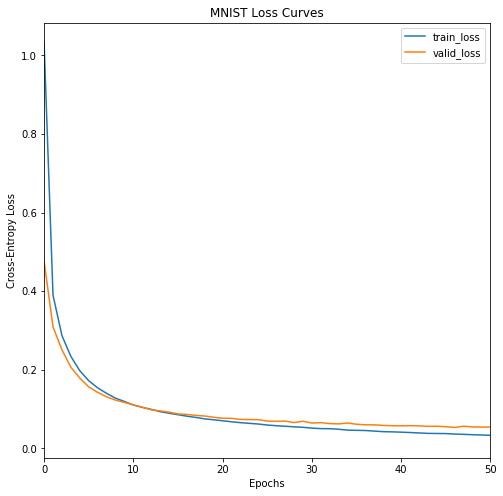

In [53]:
plt.figure(figsize=(8,8))
x = epoch_list
plt.plot(x, train_loss_list)
plt.plot(x, valid_loss_list)
plt.legend(['train_loss', 'valid_loss'], loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("Cross-Entropy Loss")
plt.title("MNIST Loss Curves")
plt.xlim(0,50)
plt.show()

In [54]:
net.load_state_dict(torch.load('model_mnist.pt'))

<All keys matched successfully>

TypeError: tensor or list of tensors expected, got <class 'numpy.ndarray'>

In [55]:
test_loss = 0.0     # making test loss is equal to 0
class_correct = list(0. for i in range(10))   # correct class list of 
class_total = list(0. for i in range(10))
j = 0
test_accuracy = 0

In [56]:
classes = ['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [57]:
net.eval()
# iterate over test data
for data, target in testloader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
        
    # forward pass: compute predicted outputs by passing inputs to the model
    output = net(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item() * data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    
    if len(target) == batch_size:
        j = batch_size
    else:
        j = len(target)
        
    for i in range(j):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1   
        
# average test loss
test_loss = test_loss/len(testloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total),
                                                      np.sum(class_correct), np.sum(class_total)))
test_accuracy = (100. * np.sum(class_correct) / np.sum(class_total))

Test Loss: 0.041589

Test Accuracy of 0 - zero: 99% (976/980)
Test Accuracy of 1 - one: 99% (1129/1135)
Test Accuracy of 2 - two: 97% (1008/1032)
Test Accuracy of 3 - three: 98% (998/1010)
Test Accuracy of 4 - four: 99% (973/982)
Test Accuracy of 5 - five: 97% (874/892)
Test Accuracy of 6 - six: 97% (936/958)
Test Accuracy of 7 - seven: 98% (1013/1028)
Test Accuracy of 8 - eight: 99% (966/974)
Test Accuracy of 9 - nine: 97% (986/1009)

Test Accuracy (Overall): 98% (9859/10000)


## Observations

Run1
1. Epochs = 100
2. batch size = 64
3. optimizer = SGD
4. alpha = 0.0005
5. training loss = 0.0208
6. validation loss = 0.0371
7. test loss = 0.036092
8. test accuracy = 98%
9. model = model_mnist.pt
10. dropout = 0.3

Run1
1. Epochs = 100
2. batch size = 64
3. optimizer = SGD
4. alpha = 0.0005
5. training loss = 0.0262
6. validation loss = 0.0494
7. test loss = 0.041589
8. test accuracy = 98%
9. model = model_mnist.pt
10. dropout = 0.1